In [51]:
# %pip install pandas tqdm scikit-learn gensim keras_preprocessing tensorflow-addons

In [52]:
# %pip install numpy<2.0

In [53]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [54]:
def conll_to_csv(conll_file, csv_file):
    data = []
    sentence_num = 1
    
    with open(conll_file, 'r') as f:
        for line in f:
            if line.strip():
                parts = line.strip().split('\t')
                if len(parts) >= 6:
                    word, pos, ner = parts[1], parts[3], parts[4]
                    data.append([word, pos, ner, sentence_num])
            else:
                sentence_num += 1  # Increment sentence number on empty lines
    
    df = pd.DataFrame(data, columns=['Word', 'POS', 'NER', 'Sentence'])
    df.to_csv(csv_file, index=False)
    return df

# Convert CoNLL to CSV
df = conll_to_csv('./encoded-dataset.conll', './encoded-dataset.csv')

In [55]:
df['NER'].value_counts()

NER
O       2823
BDD      210
CBNK     144
CDUE      98
CNUM      89
MDUE      81
ALIM      49
DTO       45
DAMT      36
CAMT      22
BGD       10
_          2
Name: count, dtype: int64

In [56]:
df['NER'].nunique()

12

In [57]:
df['Word']=df['Word'].str.lower()

In [58]:
sentences = [(list(zip(group['Word'], group['NER']))) for _, group in df.groupby('Sentence')]

In [59]:
sentences[6]

[('"', 'O'),
 ('e-statement', 'O'),
 ('of', 'O'),
 ('your', 'O'),
 ('axis', 'CBNK'),
 ('bank', 'CBNK'),
 ('credit', 'O'),
 ('card', 'O'),
 ('no', 'O'),
 ('.', 'O'),
 ('xx7854', 'CNUM'),
 ('has', 'O'),
 ('been', 'O'),
 ('generated', 'O'),
 ('.', 'O'),
 ('total', 'O'),
 ('amount', 'O'),
 ('due', 'O'),
 (':', 'O'),
 ('inr', 'CDUE'),
 ('dr', 'CDUE'),
 ('.', 'CDUE'),
 ('75030.34', 'CDUE'),
 ('.', 'O'),
 ('minimum', 'O'),
 ('amt', 'O'),
 ('due', 'O'),
 (':', 'O'),
 ('inr', 'MDUE'),
 ('dr', 'MDUE'),
 ('.', 'MDUE'),
 ('1501.00', 'MDUE'),
 (',', 'O'),
 ('due', 'O'),
 ('date', 'O'),
 (':', 'O'),
 ('07', 'BDD'),
 ('-', 'BDD'),
 ('06', 'BDD'),
 ('-', 'BDD'),
 ('24', 'BDD'),
 ('.', 'O'),
 ('visit', 'O'),
 ('https', 'O'),
 (':', 'O'),
 ('/', 'O'),
 ('/', 'O'),
 ('ccm.axbk.in', 'O'),
 ('/', 'O'),
 ('s', 'O'),
 ('/', 'O'),
 ('korhouly', 'O'),
 ('to', 'O'),
 ('view', 'O'),
 ('/', 'O'),
 ('download', 'O'),
 ('.', 'O'),
 ('"', 'O')]

In [60]:
len(sentences)

83

In [61]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
tf.test.is_gpu_available()

True

In [62]:
import xml.etree.ElementTree as ET
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import gensim.downloader as api
from tensorflow.keras.layers import Embedding

tf.random.set_seed(123)

In [64]:
words = list(set(df['Word'].values))
n_tags = list(set(df["NER"].values))
p_tags = list(set(df["POS"].values))

In [65]:
#Creating word to index and tag to index
import sklearn

# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(n_tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}

In [66]:
idx2tag[4]

'CBNK'

In [67]:
# Embedding the word matrix, we will add this
hits = 0
misses = 0
word2vec = api.load("word2vec-google-news-300")
embedding_dim = 300

# Prepare embedding matrix
embedding_matrix = np.zeros((len(word2idx), embedding_dim))
for word, i in zip(word2idx.keys(),word2idx.values()):
    embedding_vector = None
    try:
      embedding_vector = word2vec[word]
    except Exception :
      pass

    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 305 words (367 misses)


In [153]:
import gensim
w2v_model=gensim.models.Word2Vec(sentences=sentences,vector_size=300,window=10,min_count=1)

w2v_model.train(sentences,epochs=10,total_examples=len(sentences))

w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

# # Some validation on the quality of the Word2Vec model
# print(w2v_model.wv.most_similar('ICICI', topn=3))
# print(w2v_model.wv.most_similar('janeiro', topn=3))
# print(w2v_model.wv.most_similar('palmeiras', topn=3))
# print(w2v_model.wv.most_similar('ufsc', topn=3))
# print(w2v_model.wv.most_similar(positive=['rei', 'mulher'], negative=['homem'], topn=3))

def word2token(word):
    try:
        return w2v_model.wv.vocab[word].index
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty but I couldn't find a better solution right now)
    except KeyError:
        return 0
def token2word(token):
    return w2v_model.wv.index_to_key[token]


Vocabulary Size: 749 - Embedding Dim: 300


In [155]:
embed_matrix=np.zeros(shape=(vocab_size,300))
for word,i in tok.word_index.items():
  embed_vector=word_vec_dict.get(word)
  if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
    embed_matrix[i]=embed_vector
  # if word is not found then embed_vector corressponding to that vector will stay zero.


NameError: name 'tok' is not defined

In [68]:
#Tagging word to index and tag to index

#from keras.preprocessing.sequence import pad_sequences
#from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences

# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]

# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[1]] for w in s] for s in sentences]

# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=75, sequences=y, padding="post", value=tag2idx["PAD"])
from keras.utils import to_categorical

# One-Hot encode
y = [to_categorical(i, num_classes=len(n_tags)+1) for i in y]  # n_tags+1(PAD)
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape


print('Raw Sample:\n ', ' '.join([w[0] for w in sentences[1]]))
print('\n ' )
print('Raw Label:\n ', ' '.join([w[1] for w in sentences[1]]))
print('\n ' )
print('After processing, sample:\n', X[1])
print('\n ' )
print('After processing, labels:\n', y[1])

Raw Sample:
  " e-statement of your axis bank credit card no . xx3946 has been generated . total amount due inr dr . 9101.66 , minimum amount due inr dr . 456 , due date 02 - dec - 23 . click https : / / cc.axisbank.co.in / nlgvw-oxa to view / download . "

 
Raw Label:
  O O O O CBNK CBNK O O O O CNUM O O O O O O O CDUE CDUE CDUE CDUE O O O O MDUE MDUE MDUE MDUE O O O BDD BDD BDD BDD BDD O O O O O O O O O O O O O O O

 
After processing, sample:
 [251 317 425 198 582 505 175 254  61 440 486 626 340 177 440 226 154 644
  62 607 440 290 636 211 154 644  62 607 440 165 636 644 612 640 550  29
 550 579 440 301 193 224 490 490 113 490 405 462 185 490 108 440 251   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]

 
After processing, labels:
 [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [

In [69]:
len(tag2idx)

13

In [70]:
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

((74, 75), (9, 75), (74, 75, 13), (9, 75, 13))

In [71]:
y_tr = np.array(y_tr)
y_te = np.array(y_te)

In [72]:
# pip uninstall tensorflow

In [73]:
# %pip install tensorflow==2.13

In [85]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

In [160]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow_addons.utils.types import FloatTensorLike, TensorLike
from tensorflow_addons.layers import CRF
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow_addons.optimizers import AdamW

# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=len(word2idx), output_dim=300, # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN, mask_zero=True)(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(len(tag2idx))  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output
model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()


AttributeError: 'CRF' object has no attribute 'loss_function'

In [161]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow_addons.utils.types import FloatTensorLike, TensorLike
from tensorflow_addons.layers import CRF
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow_addons.optimizers import AdamW



def build_model(max_len = 75, input_dim = len(word2idx),embedding_dim = 300):
  # Model definition
  input = Input(shape=(max_len,))

  # Get embeddings
  embeddings = Embedding(
      input_dim,
      embedding_dim,
    input_length=max_len,
       mask_zero=True,
    trainable=True,
      name = 'embedding_layer'
  )(input)

  # variational biLSTM
  output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(embeddings)
  output_sequences = Bidirectional(LSTM(units=100, return_sequences=True))(output_sequences)
  # Stacking
  output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(output_sequences)

  # Adding more non-linearity
  dense_out = TimeDistributed(Dense(25, activation="relu"))(output_sequences)

  # CRF layer
  mask = Input(shape=(max_len,), dtype=tf.bool)
  crf = CRF(len(tag2idx), name='crf')
  predicted_sequence, potentials, sequence_length, crf_kernel = crf(dense_out)

  model = Model(input, potentials)
  model.compile(
      optimizer=AdamW(weight_decay=0.001),
      loss= SigmoidFocalCrossEntropy()) # Sigmoid focal cross entropy loss

  return model

model = build_model()

# Checkpointing
save_model = tf.keras.callbacks.ModelCheckpoint(filepath='ner_crf.h5',
  monitor='val_loss',
  save_weights_only=True,
  save_best_only=True,
  verbose=1
)

# Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=10)

callbacks = [save_model, es]

model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 75)]              0         
                                                                 
 embedding_layer (Embedding)  (None, 75, 300)          201600    
                                                                 
 bidirectional_24 (Bidirecti  (None, 75, 100)          140400    
 onal)                                                           
                                                                 
 bidirectional_25 (Bidirecti  (None, 75, 200)          160800    
 onal)                                                           
                                                                 
 bidirectional_26 (Bidirecti  (None, 75, 100)          100400    
 onal)                                                           
                                                           

In [162]:
history = model.fit(
  X_tr,
  y_tr,
  batch_size=64,
  epochs=100,
  validation_data=(X_te, y_te),
  callbacks=callbacks,
  shuffle=True
)

Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 3.6265 
Epoch 1: val_loss improved from inf to 1.31198, saving model to ner_crf.h5
2/2 [==============================] - 22s 6s/step - loss: 3.6265 - val_loss: 1.3120
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 1.2175
Epoch 2: val_loss improved from 1.31198 to 1.08986, saving model to ner_crf.h5
2/2 [==============================] - 0s 178ms/step - loss: 1.2175 - val_loss: 1.0899
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.9764
Epoch 3: val_loss improved from 1.08986 to 0.96520, saving model to ner_crf.h5
2/2 [==============================] - 0s 115ms/step - loss: 0.9764 - val_loss: 0.9652
Epoch 4/100
2/2 [==============================] - ETA: 0s - loss: 0.8542
Epoch 4: val_loss improved from 0.96520 to 0.89092, saving model to ner_crf.h5
2/2 [==============================] - 0s 120ms/step - loss: 0.8542 - val_loss: 0.8909
Epoch 5/100
1/2 [==============>.............

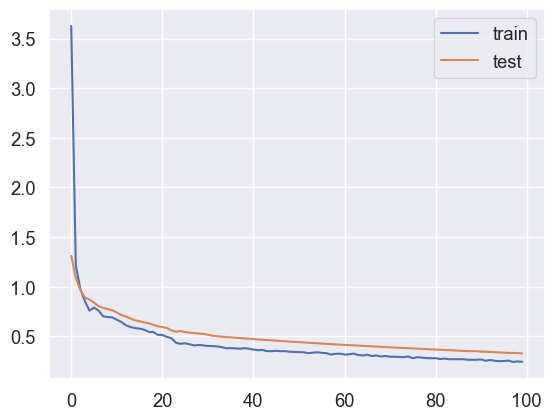

In [163]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

1/1 [==============================] - 5s 5s/step
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'BDD', 'BDD', 'BDD', 'BDD', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', '

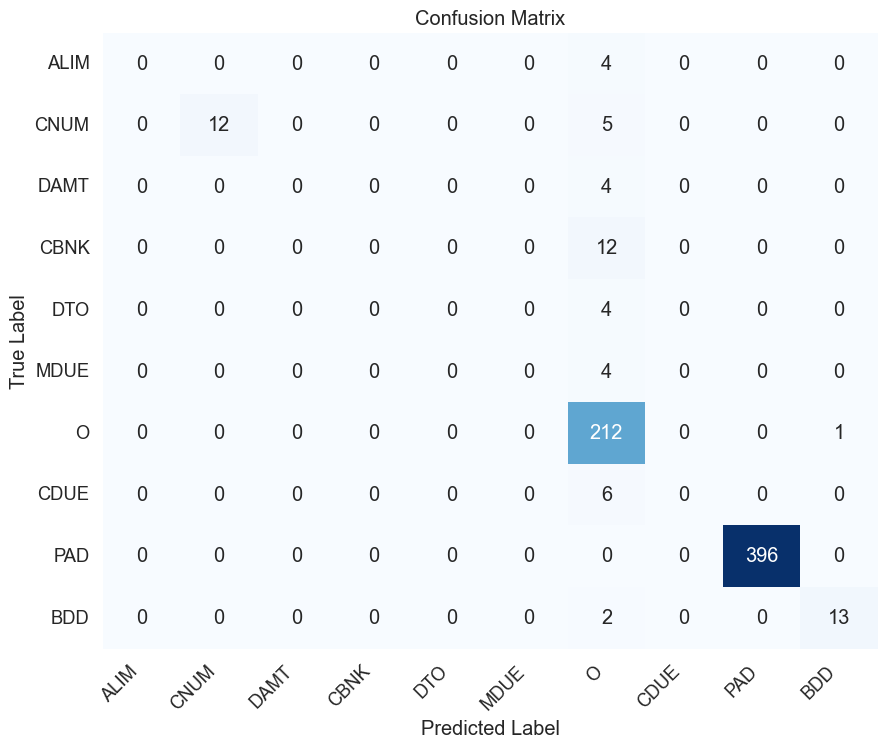

In [164]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model.predict(X_te)
# Convert predictions to POS tags
predicted_tags = np.argmax(predictions, axis=-1)
predicted_tags = [[idx2tag[tag] for tag in sample] for sample in predicted_tags]


# Flatten the predicted and true POS tag sequences
flatten_predicted = [tag for sample in predicted_tags for tag in sample]
flatten_true = [idx2tag[np.argmax(tag)] for sample in y_te for tag in sample]

print(flatten_predicted)
print(flatten_true)

# Get unique tags from the true and predicted sequences
unique_tags = list(set(flatten_true + flatten_predicted))

# Compute the confusion matrix
cm = confusion_matrix(flatten_true, flatten_predicted, labels=unique_tags)

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=unique_tags, columns=unique_tags)

# Set up the plot
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d", cbar=False)

# Customize the plot
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

# Show the plot
plt.show()

In [165]:
from sklearn.metrics import classification_report
print("Classification Report:\n ", classification_report(flatten_predicted, flatten_true, labels=unique_tags))

Classification Report:
                precision    recall  f1-score   support

        ALIM       0.00      0.00      0.00         0
        CNUM       0.71      1.00      0.83        12
        DAMT       0.00      0.00      0.00         0
        CBNK       0.00      0.00      0.00         0
         DTO       0.00      0.00      0.00         0
        MDUE       0.00      0.00      0.00         0
           O       1.00      0.84      0.91       253
        CDUE       0.00      0.00      0.00         0
         PAD       1.00      1.00      1.00       396
         BDD       0.87      0.93      0.90        14

    accuracy                           0.94       675
   macro avg       0.36      0.38      0.36       675
weighted avg       0.99      0.94      0.96       675



c:\Users\vulcan\anaconda3\envs\py39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vulcan\anaconda3\envs\py39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vulcan\anaconda3\envs\py39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
